# Thompson Sampling 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [21]:
class GaussianArm:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std 

    def sample(self):
        return np.random.normal(self.mean, self.std)         

In [26]:
arms = [GaussianArm(5, 1), GaussianArm(6, 1)]
prior_mean = 0
prior_std = 100
def posterior(prior_std, n, reward_sum):
    post_std = np.sqrt(1/((1/prior_std**2) + n))
    post_mean = (post_std**2)*reward_sum
    return np.random.normal(post_mean, post_std)

In [23]:
N_visits = 1000
num_arms = len(arms)
num_visits = [ 0 for i in range(num_arms)]
reward_sums = [ 0 for i in range(num_arms)]
scores = []
for i in range(N_visits):
    post_samples = []
    for j in range(num_arms):
        sample = posterior(prior_std, num_visits[j], reward_sums[j])
        post_samples.append(sample)
    arm_chosen = np.argmax(post_samples)
    reward = arms[arm_chosen].sample()
    reward_sums[arm_chosen] += reward 
    num_visits[arm_chosen] += 1
    scores.append(reward)

In [24]:
num_visits

[11, 989]

# Hellinger-UCB

In [1]:
import numpy as np 
import cvxpy as cp
import matplotlib.pyplot as plt


### Bernoulli Distributed Reward Functions

In [2]:
class BernoulliBandit:
    def __init__(self, p_vector):
        self.p_vector = np.array(p_vector)
        self.num_arms = self.p_vector.shape[0]

    def pull_arm(self, arm):
        return 1 if np.random.random() <= self.p_vector[arm] else 0

class BernoulliHellingerUCB:
    def __init__(self, bandit, c=0.27, T=10000):
        self.bandit = bandit
        self.c = c
        self.T = T
        self.K = self.bandit.num_arms
        self.N = np.zeros(self.K)
        self.S = np.zeros(self.K)
        self.initialize()

    def initialize(self):
        for t in range(1, self.K + 1):
            A_t = t % self.K
            self.N[A_t] = 1
            self.S[A_t] = self.bandit.pull_arm(A_t)
        self.estimate = self.S / self.N
        
    def solve(self, arm, t):
        p_hat = self.estimate[arm]
        N = self.N[arm]
        bound = 1 - np.exp(-self.c*np.log(t)/N)
        
        p = cp.Variable()
        objective = cp.Maximize(p)
        constraint = [
            1 - (cp.sqrt(p*p_hat) + cp.sqrt((1-p)*(1-p_hat)))
            <= bound,
            p >=0, 
            p <= 1
        ]
        problem = cp.Problem(objective, constraint)
        problem.solve() 
        return p.value
        
    def main(self):
        scores = []
        for t in range(self.K + 1, self.T + 1):
            action_values = []
            for k in range(self.K):
                action_values.append(self.solve(k, t))
            A_t = np.argmax(action_values)
            self.N[A_t] += 1
            reward = self.bandit.pull_arm(A_t)
            self.S[A_t] += reward
            self.estimate = self.S / self.N
            scores.append(reward) 
        return np.cumsum(scores)/np.arange(1, len(scores) + 1) 
        
            

            

In [77]:
MAB = BernoulliBandit([0.5, 0.3, 0.6, 0.45, 0.2])
agent = BernoulliHellingerUCB(MAB)

In [78]:
scores = agent.main()
agent.estimate

array([0.46354167, 0.27027027, 0.60257075, 0.39361702, 0.23333333])

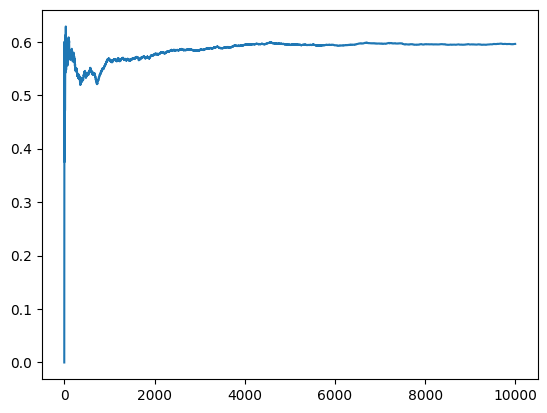

In [79]:

plt.plot(scores)
plt.show()

### Normal Distributed Reward Functions ( Std deviation assumed to be known) 

In [4]:
class FixedStdGaussianMAB:
    def __init__(self, means, std):
        self.means = np.array( means)
        self.std = std
        self.num_arms = self.means.shape[0]

    def pull_arm(self, arm):
        mean = self.means[arm]
        return np.random.normal(mean, self.std)



class GaussianHellingerUCB:
    def __init__(self, bandit, c=0.27, T=10000):
        self.bandit = bandit
        self.c = c
        self.T = T
        self.K = self.bandit.num_arms
        self.N = np.zeros(self.K)
        self.S = np.zeros(self.K)
        self.initialize()

    def initialize(self):
        for t in range(1, self.K + 1):
            A_t = t % self.K
            self.N[A_t] = 1
            self.S[A_t] = self.bandit.pull_arm(A_t)
        self.estimate = self.S / self.N
        
    def solve(self, arm, t):
        mean_hat = self.estimate[arm]
        var = (self.bandit.std)**2
        
        N = self.N[arm]
        bound = 8*self.c*np.log(t)/N
        mean = cp.Variable()
        objective = cp.Maximize(mean)
        constraint = [
            cp.square(mean-mean_hat) <= bound
           
        ]
        problem = cp.Problem(objective, constraint)
        problem.solve() 
        return mean.value
        
    def main(self):
        scores = []
        for t in range(self.K + 1, self.T + 1):
            action_values = []
            for k in range(self.K):
                action_values.append(self.solve(k, t))
            A_t = np.argmax(action_values)
            self.N[A_t] += 1
            reward = self.bandit.pull_arm(A_t)
            self.S[A_t] += reward
            self.estimate = self.S / self.N
            scores.append(reward) 
        return np.cumsum(scores)/np.arange(1, len(scores) + 1) 
        
            

MAB = FixedStdGaussianMAB([1.5, 2.3, 1.6], 0.15)
agent = GaussianHellingerUCB(MAB)
scores = agent.main()

In [5]:
agent.estimate

array([1.49530579, 2.29756981, 1.59795951])

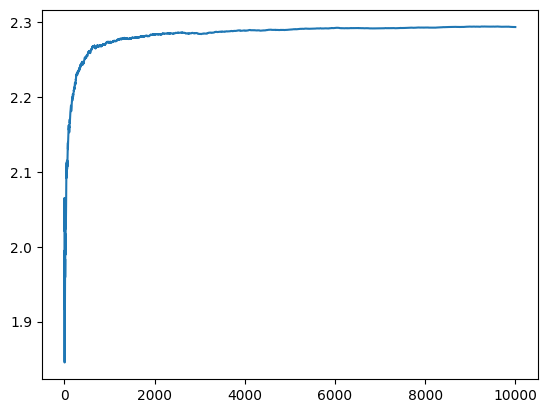

In [6]:
plt.plot(scores)
plt.show()

# Contextual Bandits

In [87]:
import numpy as np

In [104]:


bernoulli_reward = lambda p: 1 if np.random.rand() < p else 0
class LinUCB:
  def __init__(self, contexts, true_rewards, alpha=2):
    self.n_arms, self.context_dim = contexts.shape
    self.contexts = np.expand_dims(contexts, -1)
    self.true_rewards = true_rewards.reshape(-1)
    self.A = {i : np.eye(self.context_dim) for i in range(self.n_arms)}
    self.b = {i : np.zeros((self.context_dim, 1)) for i in range(self.n_arms)}
    self.alpha = alpha

  def step(self):
    action_values = []
    for i in range(self.n_arms):
      # theta_hat = np.linalg.inv(self.A[i])@self.b[i]
      theta_hat = np.linalg.solve(self.A[i], self.b[i])
      estimate = (self.contexts[i].T @ theta_hat)[0, 0]
      # bound = (self.contexts[i].T @ np.linalg.inv(self.A[i]) @ self.contexts[i])[0, 0]
      bound = (np.linalg.solve(self.A[i].T, self.contexts[i]).T @ self.contexts[i])[0, 0]
      action_values.append(estimate + self.alpha*np.sqrt(bound))
    action = np.argmax(action_values)
    reward = bernoulli_reward(self.true_rewards[action])
    self.A[action] += self.contexts[action] @ self.contexts[action].T
    self.b[action] += reward * self.contexts[action]
    return action, reward








In [105]:


class LinTS:
  def __init__(self, contexts, true_rewards, v=2):
    self.n_arms, self.context_dim = contexts.shape
    self.contexts = np.expand_dims(contexts, -1)
    self.true_rewards = true_rewards.reshape(-1)
    self.A = {i : np.eye(self.context_dim) for i in range(self.n_arms)}
    self.b = {i : np.zeros((self.context_dim, 1)) for i in range(self.n_arms)}
    self.v= v

  def step(self):
    action_values = []
    for i in range(self.n_arms):
      # theta_hat = np.linalg.inv(self.A[i])@self.b[i]
      theta_hat = np.linalg.solve(self.A[i], self.b[i])
      L = np.linalg.cholesky(self.A[i])  # A[i] = L @ L.T
      z = np.random.randn(self.context_dim)
      scaled_noise = self.v * np.linalg.solve(L.T, z)
      theta = theta_hat.reshape(-1) + scaled_noise
      action_value = self.contexts[i].T@theta
      action_values.append(action_value[0])
    action = np.argmax(action_values)
    reward = bernoulli_reward(self.true_rewards[action])
    self.A[action] += self.contexts[action] @ self.contexts[action].T
    self.b[action] += reward * self.contexts[action]
    return action, reward

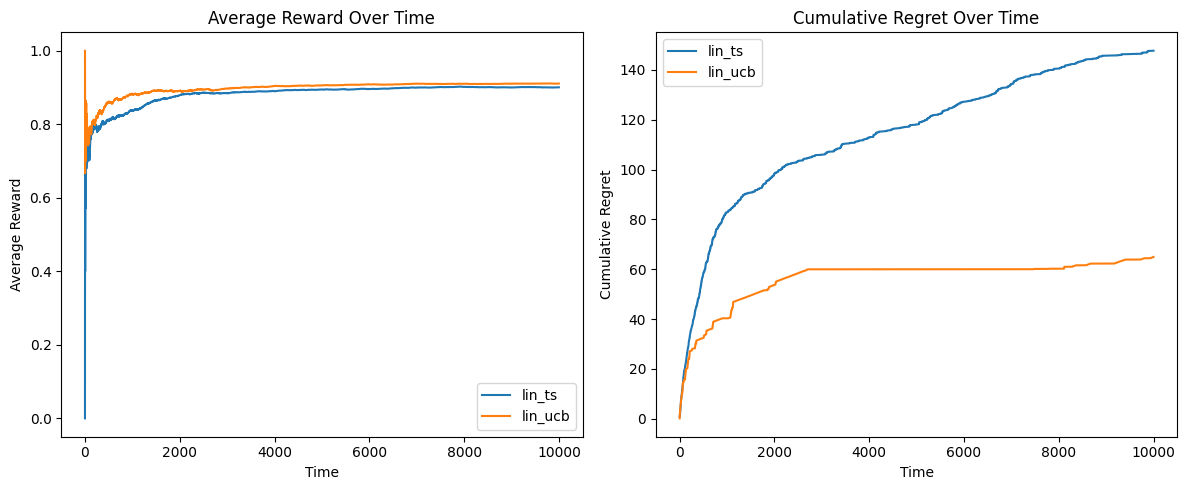

In [106]:
np.random.seed(42)
contexts = np.random.randn(20, 3)
true_rewards = 1 / (1 + np.exp(-(contexts[:, 0] + 0.5 * contexts[:, 1] - contexts[:, 2])))

lin_ucb = LinUCB(contexts, true_rewards, alpha=1)
lin_ts = LinTS(contexts, true_rewards, v=0.5)

metrics = {}
optimal_reward = np.max(true_rewards)

# LinTS
rewards_ts, regrets_ts = [], []
for _ in range(10000):
    action, reward = lin_ts.step()
    rewards_ts.append(reward)
    regrets_ts.append(optimal_reward - true_rewards[action])
metrics['lin_ts'] = [rewards_ts, regrets_ts]

#  LinUCB
rewards_ucb, regrets_ucb = [], []
for _ in range(10000):
    action, reward = lin_ucb.step()
    rewards_ucb.append(reward)
    regrets_ucb.append(optimal_reward - true_rewards[action])
metrics['lin_ucb'] = [rewards_ucb, regrets_ucb]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.xlabel("Time")
plt.ylabel("Average Reward")
plt.title('Average Reward Over Time')
for algo in metrics:
    rewards = metrics[algo][0]
    plt.plot(np.cumsum(rewards) / np.arange(1, len(rewards)+1), label=algo)
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.title('Cumulative Regret Over Time')
for algo in metrics:
    regrets = metrics[algo][1]
    plt.plot(np.cumsum(regrets), label=algo)
plt.legend()

plt.tight_layout()
plt.show()